# **Loading and Preprocessing Data with TensorFlow**

In Chapter 2, you saw that loading and preprocessing data is an important part of any machine learning project. You used Pandas to load and explore the (modified) California housing dataset—which was stored in a CSV file —and you applied Scikit-Learn’s transformers for preprocessing. These tools are quite convenient, and you will probably be using them often, especially when exploring and experimenting with data.

However, when training TensorFlow models on large datasets, you may prefer to use TensorFlow’s own data loading and preprocessing API, called ***tf.data***. It is capable of loading and preprocessing data extremely efficiently, reading from multiple files in parallel using multithreading and queuing, shuffling and batching samples, and more. Plus, it can do all of this on the fly—it loads and preprocesses the next batch of data across multiple **CPU** cores, while your **GPUs** or **TPUs** are busy training the current batch of data.

The tf.data API lets you handle datasets that don’t fit in memory, and it allows you to make full use of your hardware resources, thereby speeding up training. Off the shelf, the tf.data API can read from text files (such as CSV files), binary files with fixed-size records, and binary files that use TensorFlow’s TFRecord format, which supports records of varying sizes.

TFRecord is a flexible and efficient binary format usually containing protocol buffers (an open source binary format). The tf.data **API** also has support for reading from **SQL** databases. Moreover, many open source extensions are available to read from all sorts of data sources, such as **Google’s BigQuery** service (see *https://tensorflow.org/io*).

Keras also comes with powerful yet easy-to-use preprocessing layers that can be embedded in your models: this way, when you deploy a model to production, it will be able to ingest raw data directly, without you having to add any additional preprocessing code. This eliminates the risk of mismatch between the preprocessing code used during training and the preprocessing code used in production, which would likely cause ***training/serving skew***. And if you deploy your model in multiple apps coded in different programming languages, you won’t have to reimplement the same preprocessing code multiple times, which also reduces the risk of mismatch.

As you will see, both **APIs** can be used jointly—for example, to benefit from the efficient data loading offered by tf.data and the convenience of the Keras preprocessing layers.

In this chapter, we will first cover the tf.data **API** and the **TFRecord** format. Then we will explore the Keras preprocessing layers and how to use them with the tf.data **API**. Lastly, we will take a quick look at a few related libraries that you may find useful for loading and preprocessing data, such as TensorFlow Datasets and TensorFlow Hub. So, let’s get started!

## **The tf.data API**

The whole tf.data API revolves around the concept of a ***tf.data.Dataset***: this represents a sequence of data items. Usually you will use datasets that gradually read data from disk, but for simplicity let’s create a dataset from a simple data tensor using, ***tf.data.Dataset.from_tensor_slices()***:

In [1]:
import tensorflow as tf


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:

x = tf.range(10) # Any data tensor
dataset = tf.data.Dataset.from_tensor_slices(x)
dataset

The ***from_tensor_slices(***) function takes a tensor and creates a ***tf.data.Dataset*** whose elements are all the slices of X along the first dimension, so this dataset contains 10 items: tensors 0, 1, 2, …, 9. In this case we would have obtained the same dataset if we had used ***tf.data.Dataset.range(10)*** (except the elements would be 64-bit integers instead of 32-bit integers).

You can simply iterate over a dataset's items like this:

In [2]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


> #### **NOTE**
> The tf.data **API** is a streaming **API**: you can very efficiently iterate through a dataset’s items, but the **API** is not designed for indexing or slicing.
 
A dataset may also contain tuples of tensors, or dictionaries of name/tensor pairs, or even nested tuples and dictionaries of tensors. When slicing a tuple, a dictionary, or a nested structure, the dataset will only slice the tensors it contains, while preserving the tuple/dictionary structure. For example:

In [3]:
x_nested = {'a': ([1, 2, 3], [4, 5, 6]), 'b':[7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(x_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


### **Chaining Transformations**
Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods. Each method returns a new dataset, so you can chain transformations like this,

In [8]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In this example, we first call the ***repeat()*** method on the original dataset, and it returns a new dataset that repeats the items of the original dataset three times. Of course, this will not copy all the data in memory three times! If you call this method with no arguments, the new dataset will repeat the source dataset forever, so the code that iterates over the dataset will have to decide when to stop.

Then we call the ***batch()*** method on this new dataset, and again this creates a new dataset. This one will group the items of the previous dataset in batches of seven items.

Finally, we iterate over the items of this final dataset. ***The batch()*** method had to output a final batch of size two instead of seven, but you can call ***batch()*** with ***drop_remainder=True*** if you want it to drop this final batch, such that all batches have the exact same size.

> #### **WARNING**
>  The dataset methods do not modify datasets—they create new ones. So make sure to keep a reference to these new datasets (e.g., with ***dataset = ...***), or else nothing will happen.

You can also transform the items by calling the ***map()*** method. For example, this creates a new dataset with all batches multiplied by two:

In [10]:
dataset = dataset.map(lambda x: x * 2) # X is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


This ***map()*** method is the one you will call to apply any preprocessing to your data. Sometimes this will include computations that can be quite intensive, such as reshaping or rotating an image, so you will usually want to spawn multiple threads to speed things up. This can be done by setting the ***num_parallel_calls*** argument to the number of threads to run, or to ***tf.data.AUTOTUNE***. Note that the function you pass to the ***map()*** method must be convertible to a TF function (see Chapter 12).

It is also possible to simply filter the dataset using the ***filter()*** method. For example, this code creates a dataset that only contains the batchs whose sum is greater than 50:

In [11]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


You will often want to look at just a few items from a dataset. You can use the ***take()*** method for that:

In [12]:
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


### **Shuffling the Data**
As we discussed in Chapter 4, gradient descent works best when the instances in the training set are independent and identically distributed (**IID**). A simple way to ensure this is to shuffle the instances, using the ***shuffle()*** method. It will create a new dataset that will start by filling up a buffer with the first items of the source dataset. Then, whenever it is asked for an item, it will pull one out randomly from the buffer and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset. At this point it will continue to pull out items randomly from the buffer until it is empty. You must specify the buffer size, and it is important to make it large enough, or else shuffling will not be very effective.  Just don’t exceed the amount of **RAM** you have, though even if you have plenty of it, there’s no need to go beyond the dataset’s size. You can provide a random seed if you want the same random order every time you run your program. For example, the following code creates and displays a dataset containing the integers 0 to 9, repeated twice, shuffled using a buffer of size 4 and a random seed of 42, and batched with a batch size of 7:

In [18]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=50).batch(7)
for item in dataset:
    print(item)

tf.Tensor([3 0 4 5 7 8 2], shape=(7,), dtype=int64)
tf.Tensor([6 0 1 1 9 2 5], shape=(7,), dtype=int64)
tf.Tensor([6 4 7 9 3 8], shape=(6,), dtype=int64)


> #### **TIP**
> If you call ***repeat()*** on a shuffled dataset, by default it will generate a new order at every iteration. This is generally a good idea, but if you prefer to reuse the same order at each iteration (e.g., for tests or debugging), you can set ***reshuffle_each_iteration=False*** when calling ***shuffle()***.

For a large dataset that does not fit in memory, this simple shuffling-buffer approach may not be sufficient, since the buffer will be small compared to the dataset. One solution is to shuffle the source data itself (for example, on Linux you can shuffle text files using the ***shuf*** command). This will definitely improve shuffling a lot! Even if the source data is shuffled, you will usually want to shuffle it some more, or else the same order will be repeated at each epoch, and the model may end up being biased (e.g., due to some spurious patterns present by chance in the source data’s order). To shuffle the instances some more, a common approach is to split the source data into multiple files, then read them in a random order during training. However, instances located in the same file will still end up close to each other. To avoid this you can pick multiple files randomly and read them simultaneously, interleaving their records. Then on top of that you can add a shuffling buffer using the ***shuffle()*** method. If this sounds like a lot of work, don’t worry: the tf.data API makes all this possible in just a few lines of code. Let’s go over how you can do this.

### **Interleaving Lines from Multiple Files**
First, suppose you’ve loaded the California housing dataset, shuffled it (unless it was already shuffled), and split it into a training set, a validation set, and a test set. Then you split each set into many CSV files that each look like this (each row contains eight input features plus the target median house value):

Let’s also suppose ***train_filepaths*** contains the list of training filepaths (and you also have ***valid_filepaths*** and ***test_filepaths***):

In [ ]:
housing = tf.keras.datasets.california_housing.load_data()

In [36]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.datasets import fetch_california_housing

# Set the directory where the CSV files will be saved
data_dir = "D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/"
os.makedirs(data_dir, exist_ok=True)

# Load the California Housing dataset
housing = fetch_california_housing()
df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target

# Split the DataFrame into 3 parts and save each part as a CSV file
num_files = 4
file_paths = []
splits = np.array_split(df, num_files)
for i, split_df in enumerate(splits):
    file_path = os.path.join(data_dir, f"housing_part_{i+1}.csv")
    split_df.to_csv(file_path, index=False)
    file_paths.append(file_path)

print("Created CSV files:", file_paths)

# Create a TensorFlow Dataset from the list of file paths
files_dataset = tf.data.Dataset.from_tensor_slices(file_paths)

# Use interleave to read lines from each CSV concurrently
# Each file is processed as a TextLineDataset to read it line by line.
dataset = files_dataset.interleave(
    lambda filename: tf.data.TextLineDataset(filename),
    cycle_length=num_files,   # Number of files to read concurrently
    block_length=1            # Read one line at a time from each file before switching
)

# Print the first 10 lines from the interleaved dataset
print("\nInterleaved lines from the CSV files:")
for line in dataset.take(10):
    print(line.numpy().decode("utf-8"))


d:\CONTENTS\APPLICATIONS\New Folder\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Created CSV files: ['D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/housing_part_1.csv', 'D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/housing_part_2.csv', 'D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/housing_part_3.csv', 'D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/housing_part_4.csv']

Interleaved lines from the CSV files:
MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
8.3252,41.0,6.984126984126984,1.0238095238095237,322.0,2.5555555555555554,37.88,-122.23,4.526
1.5313,23.0,3.305,1.0183333333333333,2048.0,3.4133333333333336,33.96,-118.28,0.914
7.2554,16.0,7.577154308617234,1.0100

In [81]:
train_filepaths = [ 
                   "D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/housing_part_2.csv",
                   "D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/housing_part_3.csv",
                  ]
valid_filepaths = "D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/housing_part_1.csv"
test_filepaths = "D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/housing_part_1.csv"

In [38]:
train_filepaths

['D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/housing_part_1.csv',
 'D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/housing_part_2.csv',
 'D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/housing_part_3.csv',
 'D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/housing_part_4.csv']

Alternatively, you could use file patterns; for example, ***train_filepaths = "datasets/housing/my_train_*.csv"***. Now let’s create a dataset containing only these filepaths:

In [39]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=50)

In [33]:
#create a dataset from the File Paths
files_dataset = tf.data.Dataset.from_tensor_slices(train_filepaths)

By default, the ***list_files()*** function returns a dataset that shuffles the filepaths. In general this is a good thing, but you can set ***shuffle=False*** if you do not want that for some reason.

Next, you can call the ***interleave()*** method to read from five files at a time and interleave their lines. You can also skip the first line of each file—which is the header row—using the ***skip()*** method:

In [40]:
n_reader = 5
dataset = files_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), 
    cycle_length=n_reader
)

The ***interleave()*** method will create a dataset that will pull five filepaths from the ***filepath_dataset***, and for each one it will call the function you gave it (a lambda in this example) to create a new dataset (in this case a ***TextLineDataset***). To be clear, at this stage there will be seven datasets in all: the filepath dataset, the interleave dataset, and the five ***TextLineDatasets*** created internally by the interleave dataset. When you iterate over the interleave dataset, it will cycle through these five ***TextLineDatasets***, reading one line at a time from each until all datasets are out of items. Then it will fetch the next five filepaths from the ***filepath_dataset*** and interleave them the same way, and so on until it runs out of filepaths. For interleaving to work best, it is preferable to have files of identical length; otherwise the end of the longest file will not be interleaved.

By default, ***interleave()*** does not use parallelism; it just reads one line at a time from each file, sequentially. If you want it to actually read files in parallel, you can set the ***interleave()*** method’s ***num_parallel_calls*** argument to the number of threads you want (recall that the map() method also has this argument). You can even set it to ***tf.data.AUTOTUNE*** to make TensorFlow choose the right number of threads dynamically based on the available ***CPU***. Let’s look at what the dataset contains now:

In [41]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'8.3252,41.0,6.984126984126984,1.0238095238095237,322.0,2.5555555555555554,37.88,-122.23,4.526', shape=(), dtype=string)
tf.Tensor(b'1.5313,23.0,3.305,1.0183333333333333,2048.0,3.4133333333333336,33.96,-118.28,0.914', shape=(), dtype=string)
tf.Tensor(b'7.2554,16.0,7.577154308617234,1.0100200400801602,1665.0,3.3366733466933867,33.85,-117.78,3.356', shape=(), dtype=string)
tf.Tensor(b'3.4833,15.0,5.746153846153846,0.9769230769230769,997.0,2.556410256410256,33.15,-117.13,1.932', shape=(), dtype=string)
tf.Tensor(b'8.3014,21.0,6.238137082601054,0.9718804920913884,2401.0,2.109841827768014,37.86,-122.22,3.585', shape=(), dtype=string)


These are the First rows (ignoring the header row) of five CSV files, chosen randomly. Looks good!

> #### **NOTE**
>  It’s possible to pass a list of filepaths to the ***TextLineDataset*** constructor: it will go through each file in order, line by line. If you also set the ***num_parallel_reads*** argument to a number greater than one, then the dataset will read that number of files in parallel and interleave their lines (without having to call the ***interleave()*** method). However, it will not shuffle the files, nor will it skip the header lines.



#### **Preprocessing the Data**
Now that we have a housing dataset that returns each instance as a tensor containing a byte string, we need to do a bit of preprocessing, including parsing the strings and scaling the data. Let’s implement a couple custom functions that will perform this preprocessing:

In [72]:
import pandas as pd
train_sets = splits[1:3]

In [73]:
x_mean, x_std = tf.math.reduce_mean(pd.concat(train_sets).astype('float32'), axis=0), tf.math.reduce_std(pd.concat(train_sets).astype('float32'), axis=0)
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=x_std)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - x_mean) / x_std, y

Let's walk through this code:
- First, the code assumes that we have precomputed the mean and standard deviation of each feature in the training set. ***x_mean*** and ***x_std*** are just 1D tensors (or NumPy arrays) containing eight floats, one per input feature. This can be done using a Scikit-Learn ***StandardScaler*** on a large enough random sample of the dataset. Later in this chapter, we will use a Keras preprocessing layer instead.

- The ***parse_csv_line()*** function takes one CSV line and parses it. To help with that, it uses the ***tf.io.decode_csv()*** function, which takes two arguments: the first is the line to parse, and the second is an array containing the default value for each column in the **CSV** file. This array (***defs***) tells TensorFlow not only the default value for each column, but also the number of columns and their types. In this example, we tell it that all feature columns are floats and that missing values should default to zero, but we provide an empty array of type ***tf.float32*** as the default value for the last column (the target): the array tells TensorFlow that this column contains floats, but that there is no default value, so it will raise an exception if it encounters a missing value.
  
- The ***tf.io.decode_csv()*** function returns a list of scalar tensors (one per column), but we need to return a 1D tensor array. So we call ***tf.stack()*** on all tensors except for the last one (the target): this will stack these tensors into a 1D array. We then do the same for the target value: this makes it a 1D tensor array with a single value, rather than a scalar tensor. The ***tf.io.decode_csv()*** function is done, so it returns the input features and the target.

- Finally, the custom ***preprocess()*** function just calls the ***parse_csv_line()*** function, scales the input features by subtracting the feature means and then dividing by the feature standard deviations, and returns a tuple containing the scaled features and the target.

Let's test this preprocessing function:

In [74]:
splits[0]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
5155,1.3971,37.0,4.642857,1.094286,1243.0,3.551429,33.96,-118.26,0.898
5156,1.7656,42.0,4.144703,1.031008,1581.0,4.085271,33.96,-118.28,0.967
5157,2.1437,40.0,3.900763,1.026718,2150.0,4.103053,33.95,-118.28,0.948
5158,1.6150,42.0,4.824000,1.216000,1167.0,4.668000,33.96,-118.28,1.013


In [75]:
preprocess(b'8.3252, 41.0, 6.984127, 1.023810, 322.0, 2.555556,	37.88, 122.23, 4.526')

InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [8] vs. [9] [Op:Sub] name: 

Looks good! The ***preprocess()*** function can convert an instance from a byte string to a nice scaled tensor, with its corresponding label. We can now use the dataset’s ***map()*** method to apply the ***preprocess()*** function to each sample in the dataset.

### **Putting Everything Together**
To make the code more reusable, let’s put together everything we have discussed so far into another helper function; it will create and return a dataset that will efficiently load California housing data from multiple CSV files, preprocess it, shuffle it, and batch it

In [79]:
def csv_reader_dataset(file_paths, n_readers=5, 
                       n_read_threads=None, n_parse_threads=5, 
                       shuffled_buffer_size=10_000, seed=50, 
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(file_paths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(file_path).skip(1), 
        cycle_length = n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffled_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

Note that we use the ***prefetch()*** method on every last line. This is important for performance, as you will see now.

### **Prefetching**
By calling ***prefetch(1)*** at the end of the custom ***csv_reader_dataset()*** function, we are creating a dataset that will do its best to always be one batch ahead.  In other words, while our training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready (e.g., reading the data from disk and preprocessing it). This can improve performance dramatically, If we also ensure that loading and preprocessing are multithreaded (by setting ***num_parallel_calls*** when calling ***interleave()*** and ***map()***), we can exploit multiple CPU cores and hopefully make preparing one batch of data shorter than running a training step on the GPU: this way the GPU will be almost 100% utilized (except for the data transfer time from the CPU to the GPU ), and training will run much faster.

> #### **TIP**
>  If you plan to purchase a GPU card, its processing power and its memory size are of course very important (in particular, a large amount of RAM is crucial for large computer vision or natural language processing models). Just as important for good performance is the GPU’s memory bandwidth; this is the number of gigabytes of data it can get into or out of its RAM per second.

If the dataset is small enough to fit in memory, you can significantly speed up training by using the dataset’s ***cache()*** method to cache its content to RAM. You should generally do this after loading and preprocessing the data, but before shuffling, repeating, batching, and prefetching. This way, each instance will only be read and preprocessed once (instead of once per epoch), but the data will still be shuffled differently at each epoch, and the next batch will still be prepared in advance.

You have now learned how to build efficient input pipelines to load and preprocess data from multiple text files. We have discussed the most common dataset methods, but there are a few more you may want to look at, such as ***concatenate()***, ***zip()***, ***window()***, ***reduce()***, ***shard()***, ***flat_map()***, ***apply()***, ***unbatch()***, and ***padded_batch()***. There are also a few more class methods, such as ***from_generator()*** and ***from_ ten sors()***, which create a new dataset from a Python generator or a list of tensors, respectively. Please check the API documentation for more details. Also note that there are experimental features available in ***tf.data.experimental***, many of which will likely make it to the core API in future releases (e.g., check out the ***CsvDataset*** class, as well as the ***make_csv_dataset()*** method, which takes care of inferring the type of each column).

### **Using the Dataset with Keras**
Now we can use the custom ***csv_reader_dataset()*** function we wrote earlier to create a dataset for the training set, and for the validation set and the test set. The training set will be shuffled at each epoch (note that the validation set and the test set will also be shuffled, even though we don’t really need that):

In [82]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

Now you can simply build and train a Keras model using these datasets. When you call the model’s fit() method, you pass ***train_set*** instead of ***X_train***, ***y_train***, and ***pass validation_data=valid_set*** instead of ***validation_data=(X_valid, y_valid)***. The ***fit()*** method will take care of repeating the training dataset once per epoch, using a different random order at each epoch:

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Normalization(input_shape=train_set.shape[1:]), 
    tf.keras.layers.Dense(100, activation='relu'), 
    tf.keras.layers.Dense(75, activation='relu'), 
    tf.keras.layers.Dense(50, activation='relu'), 
    tf.keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer='sgd')
model.fit(train_set, validation_data=valid_set, epochs=5)

Similarly, you can pass a dataset to the evaluate() and predict() methods:

In [107]:
train = splits[2]

In [ ]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3) # pretend we have 3 new samples
y_pred = model.predict(new_set) # or you could just pass a numpy array.

Unlike the other sets, the ***new_set*** will usually not contain labels. If it does, as is the case here, Keras will ignore them. Note that in all these cases, you can still use NumPy arrays instead of datasets if you prefer (but of course they need to have been loaded and preprocessed first).

If you want to build your own custom training loop (as discussed in Chapter 12), you can just iterate over the training set, very naturally:

In [ ]:
n_epochs = 5
for epoch in range(n_epochs):
    for x_batch, y_batch in train_set:
        [...] # Perform one gradient descent step

In fact, it is even possible to create a TF function (see Chapter 12) that trains the model for the whole epoch. This can really speed up training:

In [ ]:
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for x_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(x_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

In Keras, the ***steps_per_execution*** argument of the ***compile()*** method lets you define the number of batches that the ***fit()*** method will process during each call to the ***tf.function*** it uses for training. The default is just 1, so if you set it to 50 you will often see a significant performance improvement. However, the ***on_batch_*()** methods of Keras callbacks will only be called every 50 batches.

Congratulations, you now know how to build powerful input pipelines using the tf.data API! However, so far we’ve been using CSV files, which are common, simple, and convenient but not really efficient, and do not support large or complex data structures (such as images or audio) very well. So, let’s see how to use TFRecords instead.

> #### **TIP**
>  If you are happy with CSV files (or whatever other format you are using), you do not have to use TFRecords. As the saying goes, if it ain’t broke, don’t fix it! TFRecords are useful when the bottleneck during training is loading and parsing the data.

## **TFRecord Format**
The TFRecord format is TensorFlow’s preferred format for storing large amounts of data and reading it efficiently. It is a very simple binary format that just contains a sequence of binary records of varying sizes (each record is comprised of a length, a CRC checksum to check that the length was not corrupted, then the actual data, and finally a CRC checksum for the data). You can easily create a TFRecord file using the ***tf.io.TFRecordWriter*** class:

In [2]:
with tf.io.TFRecordWriter('my_data.tfrecord') as f:
    f.write(b'This is the first record')
    f.write(b'This is the second record')

And you can then use a **tf.data.TFRecordDataset** to read one or more TFRecord files:

In [3]:
filepaths = ['my_data.tfrecord']
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'This is the second record', shape=(), dtype=string)


> #### **TIP**
>  By default, a ***TFRecordDataset*** will read files one by one, but you can make it read multiple files in parallel and interleave their records by passing the constructor a list of filepaths and setting ***num_parallel_reads*** to a number greater than one. Alternatively, you could obtain the same result by using ***list_files()*** and ***interleave()*** as we did earlier to read multiple **CSV** files.

### **Compresed TFRecord Files**
It can sometimes be useful to compress your TFRecord files, especially if they need to be loaded via a network connection. You can create compressed TFRecord file by setting the **options** argument:

In [4]:
options = tf.io.TFRecordOptions(compression_type='GZIP')
with tf.io.TFRecordWriter('my_compressed.tfrecord', options) as file:
    file.write(b'Compress, Compress, Compress!')

When reading a compressed TFRecord file, you need to specify the compression type:

In [7]:
dataset = tf.data.TFRecordDataset(['my_compressed.tfrecord'], compression_type='GZIP')
for item in dataset:
    print(item)

tf.Tensor(b'Compress, Compress, Compress!', shape=(), dtype=string)


### **A Brief Introduction to Protocol Buffers**
Even though each record can use any binary format you want, TFRecord files usually contain serialized protocol buffers (also called ***protobufs***). This is a portable, extensible, and efficient binary format developed at Google back in 2001 and made open source in 2008; protobufs are now widely used, in particular in **gRPC**(*https://grpc.io*), Google’s remote procedure call system. They are defined using a simple language that looks like this:

In [ ]:
"""This is the person.proto file
syntax = 'proto3'
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}
"""
# compile it in CMD on correct location useing this command.
# protoc --python_out=. person.proto

"This is the person.proto file\nsyntax = 'proto3'\nmessage Person {\n    string name = 1;\n    int32 id = 2;\n    repeated string email = 3;\n}\n"

This protobuf definition says we are using version 3 of the protobuf format, and it specifies that each ***Person*** object  may (optionally) have a ***name*** of type string, an ***id*** of type int32, and zero or more **email** fields, each of type string. The numbers 1, 2, and 3 are the field identifiers: they will be used in each record’s binary representation. Once you have a definition in a ***.proto*** file, you can compile it. This requires ***protoc***, the protobuf compiler, to generate access classes in Python (or some other language). Note that the protobuf definitions you will generally use in TensorFlow have already been compiled for you, and their Python classes are part of the TensorFlow library, so you will not need to use ***protoc***. All you need to know is how to use protobuf access classes in Python. To illustrate the basics, let’s look at a simple example that uses the access classes generated for the Person protobuf (the code is explained in the comments):

In [7]:
pip install --upgrade protobuf


Note: you may need to restart the kernel to use updated packages.


In [8]:
pip uninstall protobuf

^C
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install protobuf

Note: you may need to restart the kernel to use updated packages.


In [11]:
python -c "import google.protobuf; 
print(google.protobuf.__version__)"

SyntaxError: unterminated string literal (detected at line 1) (421991360.py, line 1)

In [6]:
from person_pb2 import Person # import the generated access

person = Person(name='AI', id=123, email=['a@b.com']) # Create a person
print(person)

person.name # read a fieled

person.name = 'Alice' # Modify a field

person.email[0] # Repeated fields can be accessed like arrays

person.email.append('c@d.com') # Add an email address

serialized

person2.Person() # Create a new person

person2.ParseFromString(serialized) # Parse the byte string (27 bytes long)

person == person2 # Now they are equal

AttributeError: module 'google.protobuf.internal.api_implementation' has no attribute '_c_module'

In [18]:
class Person:
    def __init__(self, name, id, email=[]):
        self.name = name
        self.id = id
        self.email = email
    
    def output(self):
        return f"name: {name}\nid: {id}\nemail: {email};"
    
Person('jaxon', 123, ['mamacita'])

In short, we import the ***Person*** class generated by ***protoc***, we create an instance and play with it, visualizing it and reading and writing some fields, then we serialize it using the ***SerializeToString()*** method. This is the binary data that is ready to be saved or transmitted over the network. When reading or receiving this binary data, we can parse it using the ***ParseFromString()*** method, and we get a copy of the object that was serialized.

You could save the serialized ***Person*** object to a TFRecord file, then load and parse it: everything would work fine. However, ***ParseFromString()*** is not a TensorFlow operation, so you couldn’t use it in a preprocessing function in a tf.data pipeline (except by wrapping it in a ***tf.py_function()*** operation, which would make the code slower and less portable, as you saw in Chapter 12). However, you could use the ***tf.io.decode_proto()*** function, which can parse any protobuf you want, provided you give it the protobuf definition (see the notebook for an example). That said, in practice you will generally want to use instead the predefined protobufs for which TensorFlow provides dedicated parsing operations. Let’s look at these predefined protobufs now.

### **TensorFlow Protobufs**
The main protobuf typically used in a TFRecord file is the ***Example*** protobuf, which represents one instance in a dataset. It contains a list of named features, where each feature can either be a list of byte strings, a list of floats, or a list of integers. Here is the protobuf definition (from TensorFlow’s source code):

In [12]:
"""
 syntax = "proto3";
 message BytesList { repeated bytes value = 1; }
 message FloatList { repeated float value = 1 [packed = true]; }
 message Int64List { repeated int64 value = 1 [packed = true]; }
 message Feature {
 oneof kind {
 BytesList bytes_list = 1;
 FloatList float_list = 2;
 Int64List int64_list = 3;
 }
 };
 message Features { map<string, Feature> feature = 1; };
 message Example { Features features = 1; };

"""

'\n syntax = "proto3";\n message BytesList { repeated bytes value = 1; }\n message FloatList { repeated float value = 1 [packed = true]; }\n message Int64List { repeated int64 value = 1 [packed = true]; }\n message Feature {\n oneof kind {\n BytesList bytes_list = 1;\n FloatList float_list = 2;\n Int64List int64_list = 3;\n }\n };\n message Features { map<string, Feature> feature = 1; };\n message Example { Features features = 1; };\n\n'

The definitions of ***BytesList***, ***FloatList***, and ***Int64List*** are straightforward enough. Note that [***packed = true***] is used for repeated numerical fields, for a more efficient encoding. A ***Feature*** contains either a ***BytesList***, a ***FloatList***, or an ***Int64List***. A ***Features*** (with an ***s***) contains a dictionary that maps a feature name to the corresponding feature value. And finally, an ***Example*** contains only a ***Features*** object.

> #### **NOTE**
> Why was ***Example*** even defined, since it contains no more than a ***Features*** object? Well, TensorFlow’s developers may one day decide to add more fields to it. As long as the new ***Example*** definition still contains the ***features*** field, with the same ID, it will be backward compatible. This extensibility is one of the great features of protobufs.

Here is how you could create a ***tf.train.Example*** representing the same person as earlier:

In [ ]:
from tensorflow.train import ByteList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            'name': Feature (bytes_list=BytesList(value=[b"Alice"])), 
            'id': Feature (int64_list=int64List(value=[123])),
            'emails': Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }
    )
)

The code is a bit verbose and repetitive, but you could easily wrap it inside a small helper function. Now that we have an ***Example*** protobuf, we can serialize it by calling its ***SerializeToString()*** method, then write theresulting data to a TFRecord file. Let’s write it five times to pretend we have several contacts:

In [1]:
import tensorflow as tf

with tf.io.TFRecordWriter("my_contacts.tf.record") as file:
    for _ in ranfe(5):
        file.write(person_example.SerializeToString())

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

NameError: name 'ranfe' is not defined

Normally you would write much more than five Examples! Typically, you would create a conversion script that reads from your current format (say, CSV files), creates an Example protobuf for each instance, serializes them, and saves them to several TFRecord files, ideally shuffling them in the process. This requires a bit of work, so once again make sure it is really necessary (perhaps your pipeline works fine with CSV files).

Now that we have a nice TFRecord file containing several serialized Examples, let’s try to load it.

### **Loading and Parsing Examples**
To load the serialized Example protobufs, we will use a tf.data.TFRecordDataset once again, and we will parse each Example using tf.io.parse_single_example(). It requires at least two arguments: a string scalar tensor containing the serialized data, and a description of each feature. The description is a dictionary that maps each feature name to either a tf.io.FixedLenFeature descriptor indicating the feature’s shape, type, and default value, or a tf.io.VarLenFeature descriptor indicating only the type if the length of the feature’s list may vary (such as for the "emails" feature).

The following code defines a description dictionary, then creates a TFRecordDataset and applies a custom preprocessing function to it to parse each serialized Example protobuf that this dataset contains:

In [ ]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
    }

def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).map(parse)
for parsed_example in dataset:
    print(parsed_example)

The fixed-length features are parsed as regular tensors, but the variable length features are parsed as sparse tensors. You can convert a sparse tensor to a dense tensor using tf.sparse.to_dense(), but in this case it is simpler to just access its values:

In [ ]:
tf.sparse.to_dense(parsed_example['emails'], default_value=b"")

In [ ]:
parsed_example["emails"].values

Instead of parsing examples one by one using ***tf.io.parse_single_example()***, you may want to parse them batch by batch ***using tf.io.parse_example(***):

In [ ]:
def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, 
feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(2).map(parse)

for parsed_examples in dataset:
    print(parsed_examples)  # two examples at a time

Lastly, a BytesList can contain any binary data you want, including any serialized object. For example, you can use tf.io.encode_jpeg() to encode an image using the JPEG format and put this binary data in a BytesList. Later, when your code reads the TFRecord, it will start by parsing the Example, then it will need to call tf.io.decode_jpeg() to parse the data and get the original image (or you can use tf.io.decode_image(), which can decode any BMP, GIF, JPEG, or PNG image). You can also store any tensor you want in a BytesList by serializing the tensor using tf.io.serialize_tensor() then putting the resulting byte string in a BytesList feature. Later, when you parse the TFRecord, you can parse this data using tf.io.parse_tensor(). See this chapter’s notebook at *https://homl.info/colab3* for examples of storing images and tensors in a TFRecord file.

As you can see, the Example protobuf is quite flexible, so it will probably be sufficient for most use cases. However, it may be a bit cumbersome to use when you are dealing with lists of lists. For example, suppose you want to classify text documents. Each document may be represented as a list of sentences, where each sentence is represented as a list of words. And perhaps each document also has a list of comments, where each comment is represented as a list of words. There may be some contextual data too, such as the document’s author, title, and publication date. TensorFlow’s SequenceExample protobuf is designed for such use cases.



### **Handling Lists of Lists Using the SequenceExample Protobuf**
Here is the definition of the SequenceExample protobuf:

In [ ]:
"""
message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1;};
message SequenceExample {Features context = 1;
FeatureLists feature_lists = 2; };
"""

A SequenceExample contains a Features object for the contextual data and a FeatureLists object that contains one or more named FeatureList objects (e.g., a FeatureList named "content" and another named "comments"). Each FeatureList contains a list of Feature objects, each of which may be a list of byte strings, a list of 64bit integers, or a list of floats (in this example, each Feature would represent a sentence or a comment, perhaps in the form of a list of word identifiers). Building a SequenceExample, serializing it, and parsing it is similar to building, serializing, and parsing an Example, but you must use tf.io.parse_single_sequence_example() to parse a single SequenceExample or tf.io.parse_sequence_example() to parse a batch. Both functions return a tuple containing the context features (as a dictionary) and the feature lists (also as a dictionary). If the feature lists contain sequences of varying sizes (as in the preceding example), you may want to convert them to ragged tensors using tf.RaggedTensor.from_sparse() (see the notebook for the full code):

In [ ]:
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])

Now that you know how to efficiently store, load, parse, and preprocess the data using the tf.data API, TFRecords, and protobufs, it’s time to turn our attention to the Keras preprocessing layers.

## **Keras Preprocessing Layers**
Preparing your data for a neural network typically requires normalizing the numerical features, encoding the categorical features and text, cropping and resizing images, and more. There are several options for this:
- The preprocessing can be done ahead of time when preparing your training data files, using any tools you like, such as NumPy, Pandas, or Scikit-Learn. You will need to apply the exact same preprocessing steps in production, to ensure your production model receives preprocessed inputs similar to the ones it was trained on.

- Alternatively, you can preprocess your data on the fly while loading it with tf.data, by applying a preprocessing function to every element of a dataset using that dataset’s map() method, as we did earlier in this chapter. Again, you will need to apply the same preprocessing steps in production.

- One last approach is to include preprocessing layers directly inside your model so it can preprocess all the input data on the fly during training, then use the same preprocessing layers in production. The rest of this chapter will look at this last approach.

Keras offers many preprocessing layers that you can include in your models: they can be applied to numerical features, categorical features, images, and text. We’ll go over the numerical and categorical features in the next sections, as well as basic text preprocessing, and we will cover image preprocessing in Chapter 14 and more advanced text preprocessing in Chapter 16.


### **The Normalization Layer**
As we saw in Chapter 10, Keras provides a ***Normalization*** layer that we can use to standardize the input features. We can either specify the mean and variance of each feature when creating the layer or—more simply— pass the training set to the layer’s ***adapt()*** method before fitting the model, so the layer can measure the feature means and variances on its own before training:

In [ ]:
# Before running make sure first to load the dataset and split it accordingly
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(x_train) # Computes the mean and variance of every feature
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=5)

> #### **TIP**
> The data sample passed to the ***adapt()*** method must be large enough to be representative of your dataset, but it does not have to be the full training set: for the ***Normalization*** layer, a few hundred instances randomly sampled from the training set will generally be sufficient to get a good estimate of the feature means and variances.

Since we included the Normalization layer inside the model, we can now deploy this model to production without having to worry about normalization again: the model will just handle it. This approach completely eliminates the risk of preprocessing mismatch, which happens when people try to maintain different preprocessing code for training and production but update one and forget to update the other. The production model then ends up receiving data preprocessed in a way it doesn’t expect. If they’re lucky, they get a clear bug. If not, the model’s accuracy just silently degrades.

Including the preprocessing layer directly in the model is nice and straightforward, but it will slow down training (only very slightly in the case of the Normalization layer): indeed, since preprocessing is performed on the fly during training, it happens once per epoch. We can do better by normalizing the whole training set just once before training. To do this, we can use the Normalization layer in a standalone fashion (much like a Scikit-Learn StandardScaler):

In [ ]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(x_train)
x_train_scaled = norm_layer(x_train)
x_valid_scaled = norm_layer(x_valid)

Now we can train a model on the scaled data, this time without a **Normalization** layer:

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss='mse', optimizer=tf.keras,optimizers.SGD(learning_rate=2e-3))
model.fit(x_train_scaled, y_train, epochs=5, 
          validation_data=(x_valid_scaled, y_valid))

Good! This should speed up training a bit. But now the model won’t preprocess its inputs when we deploy it to production. To fix this, we just need to create a new model that wraps both the adapted Normalization layer and the model we just trained. We can then deploy this final model to production, and it will take care of both preprocessing its inputs and making predictions.

In [ ]:
final_model = tf.keras.Sequential([norm_layer, model])
x_new = x_test[:3] # Pretent we have a few new instances (unscaled)
y_pred = final_model(x_new) # Preprocesses the data and makes predictions

Now we have the best of both worlds: training is fast because we only preprocess the data once before training begins, and the final model can preprocess its inputs on the fly without any risk of preprocessing mismatch.

Moreover, the Keras preprocessing layers play nicely with the tf.data API. For example, it’s possible to pass a ***tf.data.Dataset*** to a preprocessing layer’s ***adapt()*** method. It’s also possible to apply a Keras preprocessing layer to a ***tf.data.Dataset*** using the dataset’s ***map()*** method. For example, here’s how you could apply an adapted ***Normalization*** layer to the input features of each batch in a dataset:

In [ ]:
dataset = dataset.map(lambda x, y: (norm_layer(x), y))

Lastly, if you ever need more features than the Keras preprocessing layers provide, you can always write your own Keras layer, just like we discussed in Chapter 12. For example, if the ***Normalization*** layer didn’t exist, you could get a similar result using the following custom layer:

In [4]:
import numpy as np

class MyNormalization(tf.keras.layers.Layer):
    def adapt(self, x):
        self.mean_ = np.mean(x, axis=0, keepdims=True)
        self.std_ = np.std(x, axis=0, keepdims=True)
        
    def call(self, inputs):
        eps = tf.keras.backend.epsilon() # a small smoohting term
        return (inputs - self.mean_) / (self.std_ + eps)


Next, let's look at another keras preprocessing layer for numerical feature; the ***Discretization*** layer.

### **The Discretization Layer**
The ***Discretization*** layer’s goal is to transform a numerical feature into a categorical feature by mapping value ranges (called bins) to categories. This is sometimes useful for features with multimodal distributions, or with features that have a highly non-linear relationship with the target. For example, the following code maps a numerical ***age*** feature to three categories, less than 18, 18 to 50 (not included), and 50 or over:

In [7]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]], dtype=int64)>

In this example, we provided the desired bin boundaries. If you prefer, you can instead provide the number of bins you want, then call the layer’s ***adapt()*** method to let it find the appropriate bin boundaries based on the value percentiles. For example, if we set ***num_bins=3***, then the bin boundaries will be located at the values just below the 33rd and 66th percentiles (in this example, at the values 10 and 37):

In [6]:
discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]], dtype=int64)>

Category identifiers such as these should generally not be passed directly to a neural network, as their values cannot be meaningfully compared. Instead, they should be encoded, for example using one-hot encoding. Let’s look at how to do this now.

### **The CategoryEncoding Layer**
When there are only a few categories (e.g., less than a dozen or two), then one-hot encoding is often a good option (as discussed in Chapter 2). To do this, Keras provides the ***CategoryEncoding*** layer. For example, let’s one-hot encode the ***age_categories*** feature we just created:

In [8]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)>

If you try to encode more than one categorical feature at a time (which only makes sense if they all use the same categories), the ***CategoryEncoding*** class will perform *multi-hot encoding* by default: the output tensor will contain a 1 for each category present in any input feature. For example:

In [ ]:
two_age_categories = np.array([[1, 0,], [2, 2], [2, 0]])
onehot_layer(two_age_categories)

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.],
       [0., 1., 0.]], dtype=float32)>

If you believe it’s useful to know how many times each category occurred, you can set ***output_mode="count"*** when creating the ***CategoryEncoding*** layer, in which case the output tensor will containthe number of occurrences of each category. In the preceding example, the output would be the same except for the second row, which would become ***[0., 0., 2.]***.

Note that both multi-hot encoding and count encoding lose information, since it’s not possible to know which feature each active category came from. For example, both ***[0, 1]*** and ***[1, 0]*** are encoded as ***[1., 1., 0.]***. If you want to avoid this, then you need to one-hot encode each feature separately and concatenate the outputs. This way, ***[0, 1]*** would get encoded as ***[1., 0., 0., 0., 1., 0.]*** and ***[1, 0]*** would get encoded as ***[0., 1., 0., 1., 0., 0.]***. You can get the same result by tweaking the category identifiers so they don’t overlap. For example:

In [14]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
onehot_layer(two_age_categories + [0, 3]) # adds 3 to the second feature

<tf.Tensor: shape=(4, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>

In this output, the first three columns correspond to the first feature, and the last three correspond to the second feature. This allows the model to distinguish the two features. However, it also increases the number of features fed to the model, and thereby requires more model parameters. It’s hard to know in advance whether a single multi-hot encoding or a perfeature one-hot encoding will work best: it depends on the task, and you may need to test both options.

Now you can encode categorical integer features using one-hot or multi-hot encoding. But what about categorical text features? For this, you can use the ***StringLookup*** layer.

### **The StringLookup Layer**
Let's use the Keras ***StringLookup*** layer to one-hot encode a ***cities*** feature:

In [17]:
cities = ['Auckland', 'Paris', 'paris', 'Dar es salaam', 'San Fransisco']
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([['paris'], ['Auckland'], ['Auckland'], ['Dodoma'], ['Dar es salaam']])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1],
       [5],
       [5],
       [0],
       [4]], dtype=int64)>

We first create a ***StringLookup*** layer, then we adapt it to the data: it finds that there are four distinct categories. Then we use the layer to encode a few cities. They are encoded as integers by default. Unknown categories get mapped to 0, as is the case for “Montreal” in this example. The known categories are numbered starting at 1, from the most frequent category to the least frequent.

Conveniently, if you set ***output_mode="one_hot"*** when creating the ***StringLookup*** layer, it will output a one-hot vector for each category, instead of an integer:

In [19]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode='one_hot')
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 6), dtype=int64, numpy=
array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0]], dtype=int64)>

> #### **TIP**
> Keras also includes an ***IntegerLookup*** layer that acts much like the ***StringLookup*** layer but takes integers as input, rather than strings.

If the training set is very large, it may be convenient to adapt the layer to just a random subset of the training set. In this case, the layer’s ***adapt()*** method may miss some of the rarer categories. By default, it would then map them all to category 0, making them indistinguishable by the model. To reduce this risk (while still adapting the layer only on a subset of the training set), you can set ***num_oov_indices*** to an integer greater than 1. This is the number of out-of-vocabulary (**OOV**) buckets to use: each unknown category will get mapped pseudorandomly to one of the **OOV** buckets, using a hash function modulo the number of **OOV** buckets. This will allow the model to distinguish at least some of the rare categories. For example:

In [20]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([['Paris'], ['Auckland'], ['Foo'], ['Bar'], ['Baz']])


<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[7],
       [9],
       [4],
       [3],
       [4]], dtype=int64)>

Since there are five **OOV** buckets, the first known category’s **ID** is now 5 ("***Paris***"). But "***Foo***", "***Bar***", and "***Baz***" are unknown, so they each get mapped to one of the **OOV** buckets. "***Bar***" gets its own dedicated bucket (with ID 3), but sadly "***Foo***" and "***Baz***" happen to be mapped to the same bucket (with ID 4), so they remain indistinguishable by the model. This is called a *hashing collision*. The only way to reduce the risk of collision is to increase the number of **OOV** buckets. However, this will also increase the total number of categories, which will require more **RAM** and extra model parameters once the categories are one-hot encoded. So, don’t increase that number too much.

This idea of mapping categories pseudorandomly to buckets is called the *hashing trick*. Keras provides a dedicated layer which does just that: the ***Hashing*** layer.

### **The Hashing Layer**
For each category, the Keras ***Hashing*** layer computes a hash, modulo the number of buckets (or “bins”). The mapping is entirely pseudorandom, but stable across runs and platforms (i.e., the same category will always be mapped to the same integer, as long as the number of bins is unchanged). For example, let’s use the ***Hashing*** layer to encode a few cities:

In [21]:
hashing_layer = tf.keras.layers.Hashing(num_bins=10)
hashing_layer([['Paris'], ['Tokyo'], ['Auckland'], ['Montreal']])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]], dtype=int64)>

The benefit of this layer is that it does not need to be adapted at all, which may sometimes be useful, especially in an out-of-core setting (when the dataset is too large to fit in memory). However, we once again get a hashing collision: “Tokyo” and “Montreal” are mapped to the same ID, making them indistinguishable by the model. So, it’s usually preferable to stick to the ***StringLookup*** layer.

Let's now look at another way to encode categories: trainable embeddings.

### **Encoding Categorical Features Using Embeddings**
An embedding is a dense representation of some higher-dimensional data, such as a category, or a word in a vocabulary. If there are 50,000 possible categories, then one-hot encoding would produce a 50,000-dimensional sparse vector (i.e., containing mostly zeros). In contrast, an embedding would be a comparatively small dense vector; for example, with just 100 dimensions.

In deep learning, embeddings are usually initialized randomly, and they are then trained by gradient descent, along with the other model parameters. For example, the "***NEAR BAY***" category in the California housing dataset could be represented initially by a random vector such as [***0.131***, ***0.890***], while the "***NEAR OCEAN***" category might be represented by another random vector such as [***0.631***, ***0.791***]. In this example, we use **2D** embeddings, but the number of dimensions is a hyperparameter you can tweak.

Since these embeddings are trainable, they will gradually improve during training; and as they represent fairly similar categories in this case, gradient descent will certainly end up pushing them closer together, while it will tend to move them away from the "***INLAND***" category’s embedding. Indeed, the better the representation, the easier it will be for the neural network to make accurate predictions, so training tends to make embeddings useful representations of the categories. This is called *representation learning* (you will see other types of representation learning in Chapter 17).

> #### **WORD EMBEDDINGS**
> Not only will embeddings generally be useful representations for the task at hand, but quite often these same embeddings can be reused successfully for other tasks. The most common example of this is word embeddings (i.e., embeddings of individual words): when you are working on a natural language processing task, you are often better off reusing pretrained word embeddings than training your own.
>
> The idea of using vectors to represent words dates back to the 1960s, and many sophisticated techniques have been used to generate useful vectors, including using neural networks. But things really took off in 2013, when Tomáš Mikolov and other Google researchers published a ***paper***(*https://homl.info/word2vec*)  describing an efficient technique to learn word embeddings using neural networks, significantly outperforming previous attempts. This allowed them to learn embeddings on a very large corpus of text: they trained a neural network to predict the words near any given word and obtained astounding word embeddings. For example, synonyms had very close embeddings, and semantically related words such as *France*, *Spain*, and *Italy* ended up clustered together.
>
> It’s not just about proximity, though: word embeddings were also organized along meaningful axes in the embedding space. Here is a famous example: if you compute *King* – *Man* + *Woman* (adding and subtracting the embedding vectors of these words), then the result will be very close to the embedding of the word Queen. In other words, the word embeddings encode the concept of gender! Similarly, you can compute *Madrid* – *Spain* + *France*, and the result is close to *Paris*, which seems to show that the notion of capital city was also encoded in the embeddings.
>
> Unfortunately, word embeddings sometimes capture our worst biases. For example, although they correctly learn that *Man* is to *King as Woman is to Queen*, they also seem to learn that *Man is to Doctor as Woman is to Nurse*: quite a sexist bias! To be fair, this particular example is probably exaggerated, as was pointed out in a ***2019 paper***(*https://homl.info/fairembeds*) by Malvina Nissim et al. Nevertheless, ensuring fairness in deep learning algorithms is an important and active research topic.

Keras provides an ***Embedding*** layer, which wraps an *embedding matrix*: this matrix has one row per category and one column per embedding dimension. By default, it is initialized randomly. To convert a category **ID** to an embedding, the ***Embedding*** layer just looks up and returns the row that corresponds to that category. That’s all there is to it! For example, let’s initialize an ***Embedding*** layer with five rows and **2D** embeddings, and use it to encode some categories:

In [28]:
tf.random.set_seed(50)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.03489258,  0.01165031],
       [ 0.01562044, -0.01584639],
       [-0.03489258,  0.01165031]], dtype=float32)>

As you can see, category 2 gets encoded (twice) as the 2D vector [***-0.03489258***,  ***0.01165031***], while category 4 gets encoded as [ ***0.01562044***, ***-0.01584639***]. Since the layer is not trained yet, these encodings are just random.

> #### **WARNING**
> An ***Embedding*** layer is initialized randomly, so it does not make sense to use it outside of a model as a standalone preprocessing layer unless you initialize it with pretrained weights.

If you want to embed a categorical text attribute, you can simply chain a ***StringLookup*** layer and an ***Embedding*** layer, like this:

In [29]:
tf.random.set_seed(50)
ocean_prox = ['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    str_lookup_layer, 
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(), 
                              output_dim=2)
])

lookup_and_embed(np.array([['<1H OCEAN'], ['ISLAND'], ['<1H OCEAN']]))

<tf.Tensor: shape=(3, 1, 2), dtype=float32, numpy=
array([[[-0.04113884, -0.00564531]],

       [[-0.04500026, -0.02608566]],

       [[-0.04113884, -0.00564531]]], dtype=float32)>

Note that the number of rows in the embedding matrix needs to be equal to the vocabulary size: that’s the total number of categories, including the known categories plus the **OOV** buckets (just one by default). The ***vocabulary_size()*** method of the ***StringLookup*** class conveniently returns this number.

> #### **TIP**
>  In this example we used 2D embeddings, but as a rule of thumb embeddings typically have 10 to 300 dimensions, depending on the task, the vocabulary size, and the size of your training set. You will have to tune this hyperparameter.

Putting everything together, we can now create a Keras model that can process a categorical text feature along with regular numerical features and learn an embedding for each category (as well as for each **OOV** bucket):

In [64]:
import pandas as pd

housing = pd.read_csv("D:/CONTENTS/AI/CODE/The Fundamentals of Machine Learning/datasets/housing/housing.csv")
housing['total_bedrooms'] = housing['total_bedrooms'].fillna(housing['total_bedrooms'].median())

instances = len(housing)

data = housing.drop(columns='median_house_value')
label = housing['median_house_value']

ratio_1 = int(-(instances * 0.1))
x_train_full, x_test, y_train_full, y_test = (
    data[:ratio_1], data[ratio_1:], label[:ratio_1], label[ratio_1:]
)

train_instances = len(x_train_full)
ratio_2 = int(-(train_instances * 0.2))

x_train, x_valid, y_train, y_valid = (
    x_train_full[:ratio_2], x_train_full[ratio_2:], 
    y_train_full[:ratio_2], y_train_full[ratio_2:]
)

In [84]:
x_train_num, x_train_cat, y_train = (x_train.drop(columns="ocean_proximity"), 
                                     x_train['ocean_proximity'], y_train)

x_valid_num, x_valid_cat, y_valid = (x_valid.drop(columns='ocean_proximity'), 
                                     x_valid['ocean_proximity'], y_valid)

num_input = tf.keras.layers.Input(shape=[8], name='num')
cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name='cat')

cat_embeddings = lookup_and_embed(cat_input)
encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])

outputs_layer = tf.keras.layers.Dense(1)
outputs = outputs_layer (encoded_inputs)
model = tf.keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])
model.compile(loss='mse', optimizer='sgd')


In [95]:
history = model.fit({"num": x_train_num, "cat": x_train_cat}, y_train, epochs=5, 
                    validation_data=({'num': x_valid_num,'cat': x_valid_cat}, y_valid))

ValueError: Invalid dtype: object

In [70]:
outputs = tf.keras.layers.Dense(1)(num_input)
model = tf.keras.models.Model(inputs=num_input, outputs=[outputs])
model.compile(loss='mse', optimizer='sgd')

history = model.fit(x_train_num, y_train, epochs=5, 
                    validation_data=(x_valid_num, y_valid))

Epoch 1/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: nan - val_loss: nan
Epoch 2/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: nan - val_loss: nan
Epoch 3/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: nan - val_loss: nan
Epoch 4/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: nan - val_loss: nan
Epoch 5/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: nan - val_loss: nan


This model takes two inputs: ***num_input***, which contains eight numerical features per instance, plus ***cat_input***, which contains a single categorical text input per instance. The model uses the ***lookup_and_embed*** model we created earlier to encode each ocean-proximity category as the corresponding trainable embedding. Next, it concatenates the numerical inputs and the embeddings using the ***concatenate()*** function to produce the complete encoded inputs, which are ready to be fed to a neural network. We could add any kind of neural network at this point, but for simplicity we just add a single dense output layer, and then we create theKeras ***Model*** with the inputs and output we’ve just defined. Next we compile the model and train it, passing both the numerical and categorical inputs.

As you saw in Chapter 10, since the Input layers are named "***num***" and "***cat***", we could also have passed the training data to the ***fit()*** method using a dictionary instead of a tuple: ***{"num": X_train_num, "cat": X_train_cat}***. Alternatively, we could have passed a ***tf.data.Dataset*** containing batches, each represented as (***(X_batch_num, X_batch_cat), y_batch***) or as (***{"num": X_batch_num, "cat": X_batch_cat}, y_batch***). And of course the same goes for the validation data.

> #### **NOTE**
> One-hot encoding followed by a ***Dense*** layer (with no activation function and no biases) is equivalent to an ***Embedding*** layer. However, the ***Embedding*** layer uses way fewer computations as it avoids many multiplications by zero—the performance difference becomes clear when the size of the embedding matrix grows. The ***Dense*** layer’s weight matrix plays the role of the embedding matrix. For example, using one-hot vectors of size 20 and a ***Dense*** layer with 10 units is equivalent to using an ***Embedding*** layer with ***input_dim=20*** and ***output_dim=10***. As a result, it would be wasteful to use more embedding dimensions than the number of units in the layer that follows the ***Embedding*** layer.

Ok, now that you have learned how to encode categorical features, it's time to turn our attention to text preprocessing.

### **Text Preprocessing**


Keras provides a ***TextVectorization*** layer for basic text preprocessing. Much like the ***StringLookup*** layer, you must either pass it a vocabulary upon creation, or let it learn the vocabulary from some training data using the ***adapt()*** method. Let’s look at an example:

In [97]:
train_data = ['To be', "!(to be)", "That's the question", "Be, be, be."]
txt_vec_layer = tf.keras.layers.TextVectorization()
txt_vec_layer.adapt(train_data)
txt_vec_layer(['Be good!', "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]], dtype=int64)>

The two sentences “Be good!” and “Question: be or be?” were encoded as [2, 1, 0, 0] and [6, 2, 1, 2], respectively. The vocabulary was learned from the four sentences in the training data: “be” = 2, “to” = 3, etc. To construct the vocabulary, the adapt() method first converted the training sentences to lowercase and removed punctuation, which is why “Be”, “be”, and “be?” are all encoded as “be” = 2. Next, the sentences were split on whitespace, and the resulting words were sorted by descending frequency, producing the final vocabulary. When encoding sentences, unknown words get encoded as 1s. Lastly, since the first sentence is shorter than the second, it was padded with 0s.

> #### **TIP**
> The ***TextVectorization*** layer has many options. For example, you can preserve the case and punctuation if you want, by setting ***standardize=None***, or you can pass any standardization function you please as the ***standardize*** argument. You can prevent splitting by setting ***split=None***, or you can pass your own splitting function instead. You can set the ***output_sequence_length*** argument to ensure that the output sequences all get cropped or padded to the desired length, or you can set ***ragged=True*** to get a ragged tensor instead of a regular tensor. Please check out the documentation for more options.

The word IDs must be encoded, typically using an ***Embedding*** layer: we will do this in Chapter 16. Alternatively, you can set the ***TextVectorization*** layer’s ***output_mode*** argument to "***multi_hot***" or "***count***" to get the corresponding encodings. However, simply counting words is usually not ideal: words like “to” and “the” are so frequent that they hardly matter at all, whereas, rarer wordssuch as “basketball” are much more informative. So, rather than setting ***output_mode*** to "***multi_hot***" or "***count***", it is usually preferable to set it to "***tf_idf***", which stands for *term-frequency × inverse-document-frequency* (**TF-IDF**). This is similar to the count encoding, but words that occur frequently in the training data are downweighted, and conversely, rare words are upweighted. For example:

In [99]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode='tf_idf')
text_vec_layer.adapt(train_data)
text_vec_layer(['Be good!', 'Question: be or be?'])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

There are many TF-IDF variants, but the way the TextVectorization layer implements it is by multiplying each word count by a weight equal to log(1 + d / (f + 1)), where d is the total number of sentences (a.k.a., documents) in the training data and f counts how many of these training sentences contain the given word. For example, in this case there are d = 4 sentences in the training data, and the word “be” appears in f = 3 of these. Since the word “be” occurs twice in the sentence “Question: be or be?”, it gets encoded as 2 × log(1 + 4 / (1 + 3)) ≈ 1.3862944. The word “question” only appears once, but since it is a less common word, its encoding is almost as high: 1 × log(1 + 4 / (1 + 1)) ≈ 1.0986123. Note that the average weight is used for unknown words.

This approach to text encoding is straightforward to use and it can give fairly good results for basic natural language processing tasks, but it has several important limitations: it only works with languages that separate words with spaces, it doesn’t distinguish between homonyms (e.g., “to bear” versus “teddy bear”), it gives no hint to your model that words like “evolution” and “evolutionary” are related, etc. And if you use multi-hot, count, or TF-IDF encoding, then the order of the words is lost. So what are the other options?

One option is to use the ***TensorFlow Text library***(*https://tensorflow.org/text*), which provides more advanced text preprocessing features than the ***TextVectorization*** layer. For example, it includes several subword tokenizers capable of splitting the text into tokens smaller than words, which makes it possible for the model to more easily detect that “evolution” and “evolutionary” have something in common (more on subword tokenization in Chapter 16).

Yet another option it to use pretrained language model components. Let's look at this now.

### **Using Pretrained Language Model Components**
The ***TensorFlow Hub library***(*https://tensorflow.org/hub*) makes it easy to reuse pretrained model components in your own models, for text, image, audio, and more. These model components are called ***modules***. Simply browse the ***TF Hub repository***(*https://tfhub.dev*), find the one you need, and copy the code example into your project, and the module will be automatically downloaded and bundled into a Keras layer that you can directly include in your model. Modules typically contain both preprocessing code and pretrained weights, and they generally require no extra training (but of course, the rest of your model will certainly require training).

For example, some powerful pretrained language models are available. The most powerful are quite large (several gigabytes), so for a quick example let’s use the ***nnlm-en-dim50*** module, version 2, which is a fairly basic module that takes raw text as input and outputs 50-dimensional sentence embeddings. We’ll import TensorFlow Hub and use it to load the module, then use that module to encode two sentences to vectors:

In [39]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer('https://tfhub.dev/google/nnlm-en-dim50/2')
sentence_embeddings = hub_layer(tf.constant(['To be', "Not to be"]))
sentence_embeddings.numpy().round(2)

array([[-0.25,  0.28,  0.01,  0.1 ,  0.14,  0.16,  0.25,  0.02,  0.07,
         0.13, -0.19,  0.06, -0.04, -0.07,  0.  , -0.08, -0.14, -0.16,
         0.02, -0.24,  0.16, -0.16, -0.03,  0.03, -0.14,  0.03, -0.09,
        -0.04, -0.14, -0.19,  0.07,  0.15,  0.18, -0.23, -0.07, -0.08,
         0.01, -0.01,  0.09,  0.14, -0.03,  0.03,  0.08,  0.1 , -0.01,
        -0.03, -0.07, -0.1 ,  0.05,  0.31],
       [-0.2 ,  0.2 , -0.08,  0.02,  0.19,  0.05,  0.22, -0.09,  0.02,
         0.19, -0.02, -0.14, -0.2 , -0.04,  0.01, -0.07, -0.22, -0.1 ,
         0.16, -0.44,  0.31, -0.1 ,  0.23,  0.15, -0.05,  0.15, -0.13,
        -0.04, -0.08, -0.16, -0.1 ,  0.13,  0.13, -0.18, -0.04,  0.03,
        -0.1 , -0.07,  0.07,  0.03, -0.08,  0.02,  0.05,  0.07, -0.14,
        -0.1 , -0.18, -0.13, -0.04,  0.15]], dtype=float32)

In [35]:
pip install tensorflow-hub --target "D:\CONTENTS\APPLICATIONS\New Folder"


  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached protobuf-6.30.2-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached tf_keras-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 by

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.1.3 which is incompatible.
mdit-py-plugins 0.3.0 requires markdown-it-py<3.0.0,>=1.0.0, but you have markdown-it-py 3.0.0 which is incompatible.
numba 0.59.1 requires numpy<1.27,>=1.22, but you have numpy 2.1.3 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.1.3 which is incompatible.
streamlit 1.32.0 requires numpy<2,>=1.19.3, but you have numpy 2.1.3 which is incompatible.
streamlit 1.32.0 requires packaging<24,>=16.8, but you have packaging 24.2 which is incompatible.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 5.29.4 which is incompatible.
streamlit 1.32.0 requires rich<14,>=10.14.0, but you have rich 14.0.0 which is incompatible.
tensorboard-plugin-profile 2.19.0 requires protobuf<5

In [36]:
pip --default-timeout=100 install tensorflow-hub --target "D:\CONTENTS\APPLICATIONS\New Folder"


  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached numpy-2.2.4-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached protobuf-6.30.2-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached tf_keras-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Us

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.1.3 which is incompatible.
mdit-py-plugins 0.3.0 requires markdown-it-py<3.0.0,>=1.0.0, but you have markdown-it-py 3.0.0 which is incompatible.
numba 0.59.1 requires numpy<1.27,>=1.22, but you have numpy 2.1.3 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.1.3 which is incompatible.
streamlit 1.32.0 requires numpy<2,>=1.19.3, but you have numpy 2.1.3 which is incompatible.
streamlit 1.32.0 requires packaging<24,>=16.8, but you have packaging 24.2 which is incompatible.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 5.29.4 which is incompatible.
streamlit 1.32.0 requires rich<14,>=10.14.0, but you have rich 14.0.0 which is incompatible.
tensorboard-plugin-profile 2.19.0 requires protobuf<5

In [37]:
pip --default-timeout=200 install tensorflow-hub --target "D:\CONTENTS\APPLICATIONS\New Folder"


  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached numpy-2.2.4-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached protobuf-6.30.2-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached tf_keras-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Us

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.1.3 which is incompatible.
mdit-py-plugins 0.3.0 requires markdown-it-py<3.0.0,>=1.0.0, but you have markdown-it-py 3.0.0 which is incompatible.
numba 0.59.1 requires numpy<1.27,>=1.22, but you have numpy 2.1.3 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.1.3 which is incompatible.
streamlit 1.32.0 requires numpy<2,>=1.19.3, but you have numpy 2.1.3 which is incompatible.
streamlit 1.32.0 requires packaging<24,>=16.8, but you have packaging 24.2 which is incompatible.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 5.29.4 which is incompatible.
streamlit 1.32.0 requires rich<14,>=10.14.0, but you have rich 14.0.0 which is incompatible.
tensorboard-plugin-profile 2.19.0 requires protobuf<5

The ***hub.KerasLayer*** layer downloads the module from the given **URL**. This particular module is a *sentence encoder*: it takes strings as input and encodes each one as a single vector (in this case, a 50-dimensional vector). Internally, it parses the string (splitting words on spaces) and embeds each word using an embedding matrix that was pretrained on a huge corpus: the Google News 7B corpus (seven billion words long!). Then it computes the mean of all the word embeddings, and the result is the sentence embedding.

You just need to include this ***hub_layer*** in your model, and you’re ready to go. Note that this particular language model was trained on the English language, but many other languages are available, as well as multilingual models.

Last but not least, the excellent open source [Transformers library by Hugging Face](https://huggingface.co/docs/transformers) also makes it easy to include powerful language model components inside your own models. You can browse the [Hugging Face Hub](https://huggingface.co/model), choose the model you want, and use the provided code examples to get started. It used to contain only language models, but it has now expanded to include image models and more.

We will come back to natural language processing in more depth in Chapter 16. Let’s now look at Keras’s image preprocessing layers.

### **Image Preprocessing Layers**
The keras preprocessing API includes three image preprocessing layers:
- ***tf.keras.layers.Resizing*** resizes the input images to the desired size. For example, ***Resizing(height=100***, ***width=200***) resizes each image to 100 × 200, possibly distorting the image. If you set ***crop_to_aspect_ratio=True***, then the image will be cropped to the target image ratio, to avoid distortion.

- tf.keras.layers.Rescaling rescales the pixel values. For example, Rescal ing (scale=2/255, offset=-1) scales the values from 0 → 255 to –1 → 1.

- ***tf.keras.layers.CenterCrop*** crops the image, keeping only a center patch of the desired height and width.

For example, let’s load a couple of sample images and center-crop them. For this, we will use Scikit-Learn’s ***load_sample_images()*** function; this loads two color images, one of a Chinese temple and the other of a flower (this requires the Pillow library, which should already be installed if you are using Colab or if you followed the installation instructions):

In [16]:
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt

images = load_sample_images()['images']
crop_image_layer = tf.keras.layers.CenterCrop(height=100, width=100)
crop_images = crop_image_layer(images)

crop_images[0]


<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[ 27.,  41.,  44.],
        [ 27.,  49.,  46.],
        [ 28.,  48.,  47.],
        ...,
        [231., 230., 236.],
        [231., 230., 236.],
        [232., 231., 237.]],

       [[ 36.,  39.,  46.],
        [ 20.,  31.,  33.],
        [ 51.,  58.,  64.],
        ...,
        [232., 231., 237.],
        [232., 231., 237.],
        [232., 231., 237.]],

       [[ 24.,  38.,  39.],
        [ 29.,  44.,  51.],
        [ 16.,  26.,  28.],
        ...,
        [232., 231., 236.],
        [232., 231., 237.],
        [232., 231., 236.]],

       ...,

       [[ 70.,  13.,   0.],
        [180.,  90.,  27.],
        [255., 176., 116.],
        ...,
        [192., 203., 199.],
        [192., 203., 199.],
        [193., 204., 200.]],

       [[101.,  52.,  22.],
        [135.,  38.,   3.],
        [252., 151.,  83.],
        ...,
        [194., 205., 201.],
        [194., 206., 202.],
        [194., 206., 202.]],

       [[145., 10

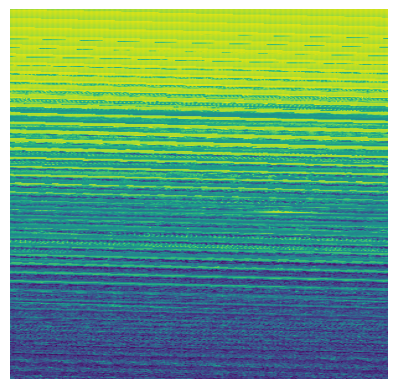

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Given array size
size = 819840

# possible dimensions (x, y)
possible_x = [i for i in range(1, int(np.sqrt(size)) + 1) if size % i == 0]
possible_shapes = [(x, size // x) for x in possible_x]

# Selecting the most square-like shape
x, y = min(possible_shapes, key=lambda s: abs(s[0] - s[1]))

image, picture = images[0], images[1]
new_image_0 = image.reshape((x, y))
new_image_1 = picture.reshape((x, y))
 
plt.imshow(new_image_0)
plt.axis('off')
plt.show()

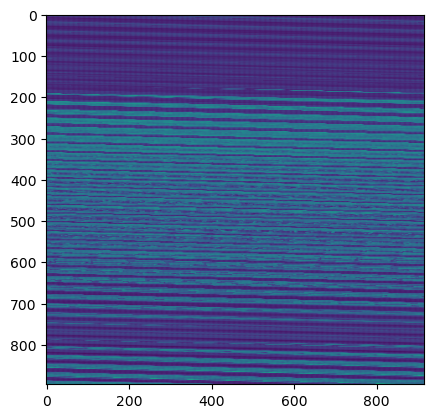

In [24]:
plt.imshow(new_image_1)

Keras also includes several layers for data augmentation, such as ***RandomCrop***, ***RandomFlip***, ***RandomTranslation***, ***RandomRotation***, ***RandomZoom***, ***RandomHeight***, ***RandomWidth***, and ***RandomContrast***. These layers are only active during training, and they randomly apply some transformation to the input images (their names are self-explanatory). Data augmentation will artificially increase the size of the training set, which often leads to improved performance, as long as the transformed images look like realistic (nonaugmented) images. We’ll cover image processing more closely in the next chapter.

> #### **NOTE**
>  Under the hood, the Keras preprocessing layers are based on TensorFlow’s low-level API. For example, the ***Normalization*** layer uses ***tf.nn.moments()*** to compute both the mean and variance, the ***Discretization*** layer uses ***tf.raw_ops.Bucketize()***, ***CategoricalEncoding*** uses ***tf.math.bincount()***, ***IntegerLookup*** and ***StringLookup*** use the ***tf.lookup package***, ***Hashing*** and ***TextVectorization*** use several ops from the ***tf.strings*** package, ***Embedding*** uses ***tf.nn.embedding_lookup()***, and the image preprocessing layers use the ops from the ***tf.image*** package. If the Keras preprocessing API isn’t sufficient for your needs, you may occasionally need to use TensorFlow’s low-level API directly.

Now let's look at another way to load data easily and efficiently in TensorFlow.

## **The TensorFlow Datasets Project**
The [TensorFlow Datasets (TFDS)](https://tensorflow.org/datasets) project makes it very easy to load common datasets, from small ones like MNIST or Fashion MNIST to huge datasets like ImageNet (you will need quite a bit of disk space!). The list includes image datasets, text datasets (including translation datasets), audio and video datasets, time series, and much more. You can visit *https://homl.info/tfds* to view the full list, along with a description of each dataset. You can also check out [Know Your Data](https://knowyourdata.withgoogle.com), which is a tool to explore and understand many of the datasets provided by TFDS.

TFDS is not bundled with TensorFlow, but if you are running on Colab or if you followed the installation instructions at *https://homl.info/install*, then it’s already installed. You can then import ***tensorflow_datasets***, usually as ***tfds***, then call the ***tfds.load()*** function, which will download the data you want (unless it was already downloaded earlier) and return the data as a dictionary of datasets (typically one for training and one for testing, but this depends on the dataset you choose). For example, let’s download MNIST:

In [29]:
pip install tensorflow-datasets


Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 5.29.4 which is incompatible.
tensorboard-plugin-profile 2.19.0 requires protobuf<5.0.0dev,>=3.19.6, but you have protobuf 5.29.4 which is incompatible.


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.3 MB ? eta -:--:--
   ------------- -------------------------- 1.8/5.3 MB 6.3 MB/s eta 0:00:01
   --------------------------------- ------ 4.5/5.3 MB 8.9 MB/s eta 0:00:01
   ---------------------------------------- 5.3/5.3 MB 8.7 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21544 sha256=34ae0c0d8992a6550ee512c310952adbc2d8551a3e2cdfa3441bf17719b42a0b
  Stored in directory: c:\users\jacks\appdata\local\pip\cache\wheels\e7\e6\28\864bdfee5339dbd6ddcb5a186286a8e217648ec198bdf0097d
Successfully built promise
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.30.2
    Uninstalling protobuf-6.30.2:
      Successfully uninstalled pr

In [32]:
import tensorflow_datasets as tfds

datasets = tfds.load(name='mnist')
mnist_train, mnist_test = datasets['train'], datasets['test']

You can then apply any transformation you want (typically shuffling, batching, and prefetching), and you’re ready to train your model. Here is a simple example:

In [38]:
for batch in mnist_train.shuffle(10_000, seed=50).batch(32).prefetch(1):
    images = batch['image']
    labels = batch['label']

> #### **TIP**
> The ***load()*** function can shuffle the files in downloads: just set ***shuffle_files-True***. However, this may be insufficient, so it's best to shuffle the training data some more.

Note that each item in the dataset is a dictionary containing both the features and the labels. But Keras expects each item to be a tuple containing two elements (again, the features and the labels). You could transform the dataset using the ***map()*** method, like this:

In [41]:
mnist_train = mnist_train.shuffle(buffer_size=10_000, seed=50).batch(32)
mnist_train = mnist_train.map(lambda items: (items['image'], items['label']))
mnist_train = mnist_train.prefetch(1)

But it’s simpler to ask the ***load()*** function to do this for you by setting ***as_supervised=True*** (obviously this works only for labeled datasets).

Lastly, TFDS provides a convenient way to split the data using the ***split*** argument. For example, if you want to use the first 90% of the training set for training, the remaining 10% for validation, and the whole test set for testing, then you can set ***split=["train[:90%]"***, ***"train[90%:]"***, ***"test"]***. The ***load()*** function will return all three sets. Here is a complete example, loading and splitting the MNIST dataset using TFDS, then using these sets to train and evaluate a simple Keras model:

In [43]:
train_set, valid_set, test_set = tfds.load(name='mnist', split=['train[:90%]', 'train[90%:]', 'test'], as_supervised=True)

train_set = train_set.shuffle(buffer_size=10_000, seed=50).batch(32).prefetch(1)
valid_set = valid_set.batch(32).cache()
test_set = test_set.batch(32).cache()

tf.random.set_seed(50)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)), 
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
history = model.fit(train_set, validation_data=valid_set, epochs=5)
test_loss, test_accuracy = model.evaluate(test_set)

Epoch 1/5


d:\CONTENTS\APPLICATIONS\New folder\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7580 - loss: 18.9900 - val_accuracy: 0.8752 - val_loss: 6.0906
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8777 - loss: 5.7757 - val_accuracy: 0.8873 - val_loss: 5.6562
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8838 - loss: 5.1927 - val_accuracy: 0.8648 - val_loss: 6.3325
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8853 - loss: 4.9395 - val_accuracy: 0.8822 - val_loss: 5.5951
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8897 - loss: 4.7977 - val_accuracy: 0.8900 - val_loss: 5.1146
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9030 - loss: 4.7479


Congratulations, you’ve reached the end of this quite technical chapter! You may feel that it is a bit far from the abstract beauty of neural networks, but the fact is deep learning often involves large amounts of data, and knowing how to load, parse, and preprocess it efficiently is a crucial skill to have. In the next chapter, we will look at convolutional neural networks, which are among the most successful neural net architectures for image processing and many other applications.